In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 1

In [3]:

#Load dataset
def load_dataset(path=r'dataset_test_v3.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  df_aux = df.drop(columns=['nr_ruas_afetadas', 'comprimento_fila_metros', 'demora_fila_segundos'], inplace=False)
  df_aux["data"] = pd.to_datetime(df_aux["data"])
  df_aux = df_aux.sort_values('data')
  df_aux = df_aux.set_index('data')
  return df_aux

In [6]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    #df[['cases']] = scaler.fit_transform(df[['cases']])
    # df[['nr_ruas_afetadas']] = scaler.fit_transform(df[['nr_ruas_afetadas']])
    df[['Nr_acidentes']] = scaler.fit_transform(df[['Nr_acidentes']])
    # df[['comprimento_fila_metros']] = scaler.fit_transform(df[['comprimento_fila_metros']])
    # df[['demora_fila_segundos']] = scaler.fit_transform(df[['demora_fila_segundos']])

    return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  # plt.plot(epochs_range,mae,label='Training MAE')
  # plt.plot(epochs_range,val_mae,label='Validation MAE')
  # plt.plot(epochs_range,rmse,label='Training RMSE')
  # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [9]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
# 1 LSTM, 1 LSTM, 2 Densas
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
    #Add a new layer
    model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #

    model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
    model.add(tf.keras.layers.Dense(n_variate, activation='linear'))

    #model summary (and save it as PNG)
    tf.keras.utils.plot_model(model, 'accidents_model.png', show_shapes=True)
    model.summary()
    return model

In [12]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [13]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0]]],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(14,6))
  plt.plot(range(len(data)), data['Nr_acidentes'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Nr de Acidentes em Braga')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
'''tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 4 },
                2: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 4 },
                3: {'timesteps' : 7, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 4 },

                #
                4: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits': 10, 'epochs' : 10,  'batch_size' : 2 },
                5: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 50,  'batch_size' : 2 },
                6: {'timesteps' : 14, 'multisteps' : 100, 'cv_splits' : 10, 'epochs' : 100,  'batch_size' : 2 }#,
                #
                #7: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits': 5, 'epochs' : 10,  'batch_size' : 1 },
                #8: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 50,  'batch_size' : 1 },
                #9: {'timesteps' : 30, 'multisteps' : 100, 'cv_splits' : 5, 'epochs' : 100,  'batch_size' : 1 }

                }'''

tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}

# record da history de cada modelo
record = {}

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
16/16 [==============================] - 5s 87ms/step - loss: 0.2931 - mae: 0.2559 - rmse: 0.2932 - val_loss: 0.3250 - val_mae: 0.2830 - val_rmse: 0.3038
Epoch 2/10
16/16 [==============================] - 0s 12ms/step - loss: 0.2539 - mae

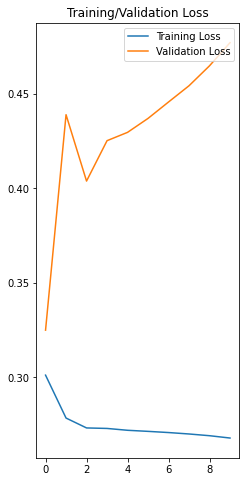

Epoch 1/10
31/31 [==============================] - 2s 11ms/step - loss: 0.3395 - mae: 0.2961 - rmse: 0.3395 - val_loss: 0.2464 - val_mae: 0.2125 - val_rmse: 0.2522
Epoch 2/10
31/31 [==============================] - 0s 8ms/step - loss: 0.3341 - mae: 0.2842 - rmse: 0.3341 - val_loss: 0.2420 - val_mae: 0.2069 - val_rmse: 0.2333
Epoch 3/10
31/31 [==============================] - 0s 9ms/step - loss: 0.3202 - mae: 0.2740 - rmse: 0.3202 - val_loss: 0.2479 - val_mae: 0.2107 - val_rmse: 0.2419
Epoch 4/10
31/31 [==============================] - 0s 9ms/step - loss: 0.3148 - mae: 0.2690 - rmse: 0.3148 - val_loss: 0.2478 - val_mae: 0.2107 - val_rmse: 0.2452
Epoch 5/10
31/31 [==============================] - 0s 8ms/step - loss: 0.3120 - mae: 0.2661 - rmse: 0.3120 - val_loss: 0.2472 - val_mae: 0.2097 - val_rmse: 0.2457

Epoch 00005: val_loss improved from 0.42966 to 0.24724, saving model to my_model_5_0.247.h5
Epoch 6/10
31/31 [==============================] - 0s 9ms/step - loss: 0.3101 - mae: 

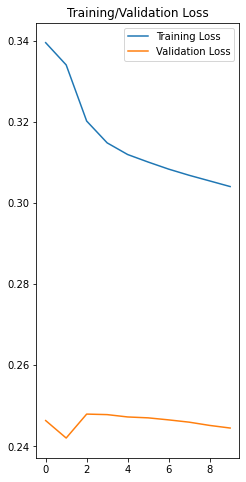

Epoch 1/10
47/47 [==============================] - 1s 26ms/step - loss: 0.2911 - mae: 0.2479 - rmse: 0.2940 - val_loss: 0.4843 - val_mae: 0.4367 - val_rmse: 0.4843
Epoch 2/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2911 - mae: 0.2471 - rmse: 0.2938 - val_loss: 0.4594 - val_mae: 0.4197 - val_rmse: 0.4594
Epoch 3/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2929 - mae: 0.2489 - rmse: 0.2956 - val_loss: 0.4411 - val_mae: 0.4049 - val_rmse: 0.4411
Epoch 4/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2914 - mae: 0.2475 - rmse: 0.2942 - val_loss: 0.4390 - val_mae: 0.4001 - val_rmse: 0.4390
Epoch 5/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2891 - mae: 0.2451 - rmse: 0.2919 - val_loss: 0.4325 - val_mae: 0.3922 - val_rmse: 0.4325

Epoch 00005: val_loss did not improve from 0.24451
Epoch 6/10
47/47 [==============================] - 0s 9ms/step - loss: 0.2873 - mae: 0.2434 - rmse: 0.2902 - val_loss: 0.4220 

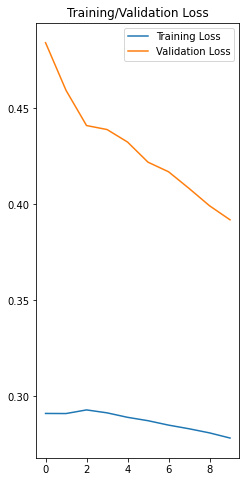

[array([[162.23477]], dtype=float32), array([[298.1917]], dtype=float32), array([[302.411]], dtype=float32), array([[161.11809]], dtype=float32), array([[225.64203]], dtype=float32), array([[314.82663]], dtype=float32), array([[159.93384]], dtype=float32), array([[230.34518]], dtype=float32), array([[284.48334]], dtype=float32), array([[264.4391]], dtype=float32), array([[213.65436]], dtype=float32), array([[257.60828]], dtype=float32), array([[271.383]], dtype=float32), array([[212.6628]], dtype=float32), array([[262.2976]], dtype=float32)]
[162.23477, 298.1917, 302.411, 161.11809, 225.64203, 314.82663, 159.93384, 230.34518, 284.48334, 264.4391, 213.65436, 257.60828, 271.383, 212.6628, 262.2976]


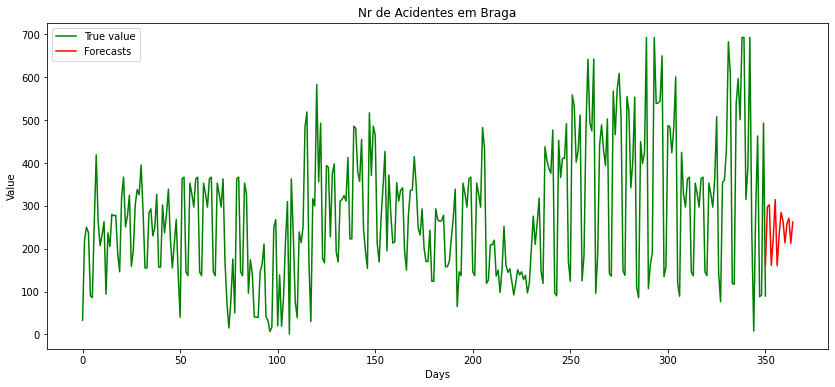

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 64)             16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 4s 66ms/step - loss: 0.2966 - mae: 0.2593 - rmse: 0.2967 - val_loss: 0.3251 - val_mae: 0.2857 - val_rmse: 0.3026
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.2541 - m

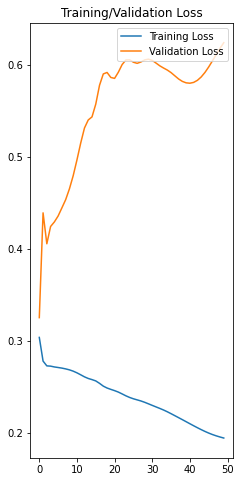

Epoch 1/50
31/31 [==============================] - 2s 11ms/step - loss: 0.3593 - mae: 0.3157 - rmse: 0.3593 - val_loss: 0.2237 - val_mae: 0.1998 - val_rmse: 0.2254
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.2986 - mae: 0.2521 - rmse: 0.2986 - val_loss: 0.2269 - val_mae: 0.1922 - val_rmse: 0.2288
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.2879 - mae: 0.2434 - rmse: 0.2879 - val_loss: 0.2240 - val_mae: 0.1837 - val_rmse: 0.2319
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.2855 - mae: 0.2417 - rmse: 0.2855 - val_loss: 0.2203 - val_mae: 0.1819 - val_rmse: 0.2284
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.2833 - mae: 0.2389 - rmse: 0.2833 - val_loss: 0.2180 - val_mae: 0.1844 - val_rmse: 0.2235

Epoch 00005: val_loss improved from 0.42905 to 0.21802, saving model to my_model_5_0.218.h5
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.2805 - mae: 

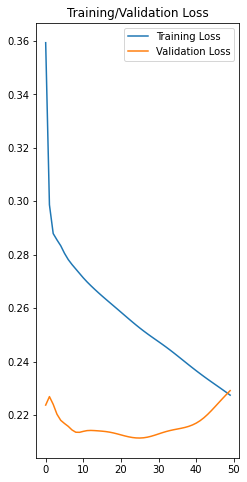

Epoch 1/50
47/47 [==============================] - 2s 34ms/step - loss: 0.2272 - mae: 0.1904 - rmse: 0.2315 - val_loss: 0.5060 - val_mae: 0.4235 - val_rmse: 0.5060
Epoch 2/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2324 - mae: 0.1975 - rmse: 0.2365 - val_loss: 0.4022 - val_mae: 0.3567 - val_rmse: 0.4022
Epoch 3/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2274 - mae: 0.1927 - rmse: 0.2316 - val_loss: 0.4873 - val_mae: 0.4128 - val_rmse: 0.4873
Epoch 4/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2274 - mae: 0.1924 - rmse: 0.2316 - val_loss: 0.4567 - val_mae: 0.4107 - val_rmse: 0.4567
Epoch 5/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2253 - mae: 0.1909 - rmse: 0.2296 - val_loss: 0.5193 - val_mae: 0.4454 - val_rmse: 0.5193

Epoch 00005: val_loss did not improve from 0.21144
Epoch 6/50
47/47 [==============================] - 0s 10ms/step - loss: 0.2250 - mae: 0.1906 - rmse: 0.2293 - val_loss: 0.

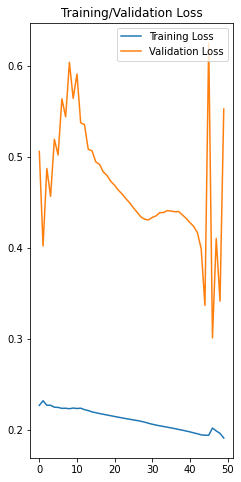

[array([[66.690506]], dtype=float32), array([[211.12206]], dtype=float32), array([[163.6762]], dtype=float32), array([[173.6535]], dtype=float32), array([[208.88896]], dtype=float32), array([[132.86943]], dtype=float32), array([[79.57753]], dtype=float32), array([[70.72543]], dtype=float32), array([[156.71167]], dtype=float32), array([[228.82497]], dtype=float32), array([[178.15477]], dtype=float32), array([[113.42694]], dtype=float32), array([[141.63503]], dtype=float32), array([[71.973236]], dtype=float32), array([[60.6935]], dtype=float32)]
[66.690506, 211.12206, 163.6762, 173.6535, 208.88896, 132.86943, 79.57753, 70.72543, 156.71167, 228.82497, 178.15477, 113.42694, 141.63503, 71.973236, 60.6935]


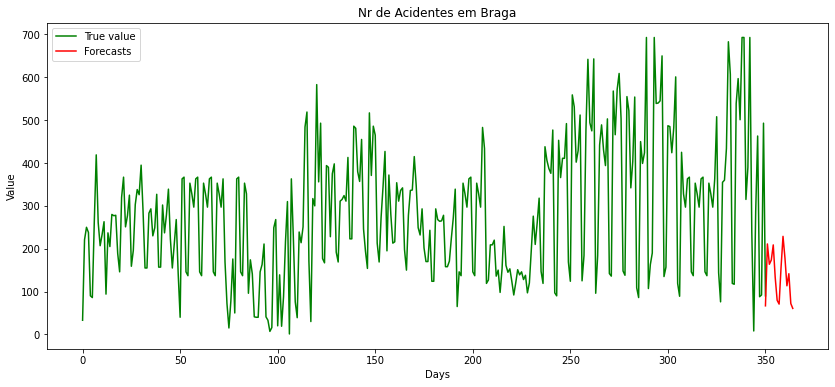

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 64)             16896     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
16/16 [==============================] - 4s 66ms/step - loss: 0.2927 - mae: 0.2556 - rmse: 0.2927 - val_loss: 0.3215 - val_mae: 0.2837 - val_rmse: 0.2994
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.2548 -

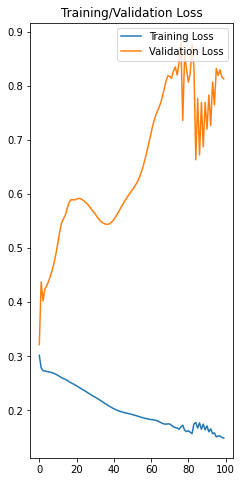

Epoch 1/100
31/31 [==============================] - 2s 11ms/step - loss: 0.3376 - mae: 0.2910 - rmse: 0.3376 - val_loss: 0.2136 - val_mae: 0.1773 - val_rmse: 0.2116
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.2943 - mae: 0.2501 - rmse: 0.2943 - val_loss: 0.2364 - val_mae: 0.1984 - val_rmse: 0.2553
Epoch 3/100
31/31 [==============================] - 0s 10ms/step - loss: 0.2872 - mae: 0.2449 - rmse: 0.2872 - val_loss: 0.2161 - val_mae: 0.1869 - val_rmse: 0.2305
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 0.2810 - mae: 0.2400 - rmse: 0.2810 - val_loss: 0.2138 - val_mae: 0.1897 - val_rmse: 0.2235
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.2741 - mae: 0.2328 - rmse: 0.2741 - val_loss: 0.2181 - val_mae: 0.1915 - val_rmse: 0.2290

Epoch 00005: val_loss improved from 0.43001 to 0.21813, saving model to my_model_5_0.218.h5
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 0.27

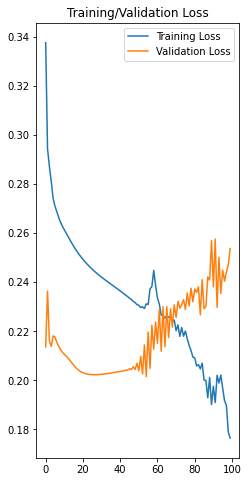

Epoch 1/100
47/47 [==============================] - 2s 37ms/step - loss: 0.2053 - mae: 0.1701 - rmse: 0.2090 - val_loss: 0.6191 - val_mae: 0.5371 - val_rmse: 0.6191
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2268 - mae: 0.1885 - rmse: 0.2306 - val_loss: 0.3145 - val_mae: 0.2597 - val_rmse: 0.3145
Epoch 3/100
47/47 [==============================] - 1s 11ms/step - loss: 0.2360 - mae: 0.1955 - rmse: 0.2398 - val_loss: 0.3884 - val_mae: 0.3162 - val_rmse: 0.3884
Epoch 4/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2119 - mae: 0.1791 - rmse: 0.2156 - val_loss: 0.4036 - val_mae: 0.3344 - val_rmse: 0.4036
Epoch 5/100
47/47 [==============================] - 1s 11ms/step - loss: 0.2071 - mae: 0.1748 - rmse: 0.2108 - val_loss: 0.4380 - val_mae: 0.3735 - val_rmse: 0.4380

Epoch 00005: val_loss did not improve from 0.20151
Epoch 6/100
47/47 [==============================] - 0s 10ms/step - loss: 0.2045 - mae: 0.1718 - rmse: 0.2084 - val_lo

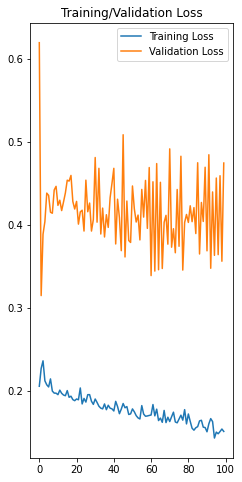

[array([[99.62283]], dtype=float32), array([[232.96175]], dtype=float32), array([[209.15082]], dtype=float32), array([[311.31155]], dtype=float32), array([[360.52625]], dtype=float32), array([[386.77368]], dtype=float32), array([[178.67773]], dtype=float32), array([[136.68228]], dtype=float32), array([[241.81857]], dtype=float32), array([[256.43942]], dtype=float32), array([[238.92097]], dtype=float32), array([[196.9633]], dtype=float32), array([[251.70312]], dtype=float32), array([[212.22812]], dtype=float32), array([[201.11803]], dtype=float32)]
[99.62283, 232.96175, 209.15082, 311.31155, 360.52625, 386.77368, 178.67773, 136.68228, 241.81857, 256.43942, 238.92097, 196.9633, 251.70312, 212.22812, 201.11803]


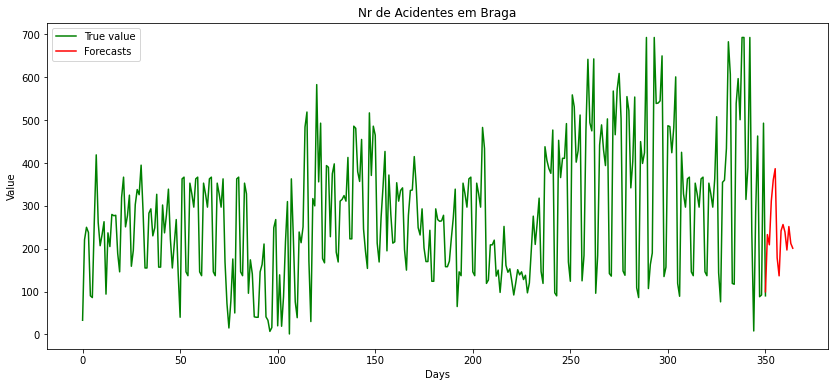

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 8, 64)             16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
16/16 [==============================] - 4s 70ms/step - loss: 0.2891 - mae: 0.2522 - rmse: 0.2895 - val_loss: 0.3347 - val_mae: 0.3008 - val_rmse: 0.3119
Epoch 2/60
16/16 [==============================] - 0s 14ms/step - loss: 0.2171 - m

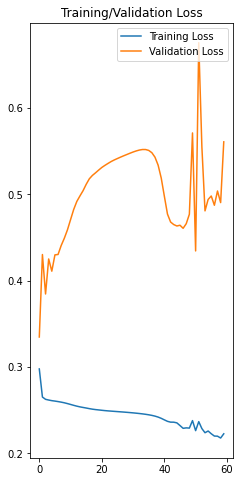

Epoch 1/60
31/31 [==============================] - 0s 15ms/step - loss: 0.3042 - mae: 0.2670 - rmse: 0.3032 - val_loss: 0.2333 - val_mae: 0.2007 - val_rmse: 0.2397
Epoch 2/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2911 - mae: 0.2524 - rmse: 0.2899 - val_loss: 0.2581 - val_mae: 0.2239 - val_rmse: 0.2678
Epoch 3/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2874 - mae: 0.2485 - rmse: 0.2862 - val_loss: 0.2543 - val_mae: 0.2240 - val_rmse: 0.2628
Epoch 4/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2846 - mae: 0.2456 - rmse: 0.2835 - val_loss: 0.2544 - val_mae: 0.2196 - val_rmse: 0.2668
Epoch 5/60
31/31 [==============================] - 0s 12ms/step - loss: 0.2822 - mae: 0.2419 - rmse: 0.2811 - val_loss: 0.2544 - val_mae: 0.2212 - val_rmse: 0.2665

Epoch 00005: val_loss improved from 0.41101 to 0.25439, saving model to my_model_5_0.254.h5
Epoch 6/60
31/31 [==============================] - 0s 13ms/step - loss: 0.2808 - 

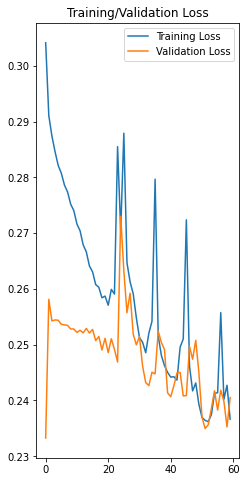

Epoch 1/60
47/47 [==============================] - 1s 31ms/step - loss: 0.2438 - mae: 0.2061 - rmse: 0.2472 - val_loss: 0.4165 - val_mae: 0.3542 - val_rmse: 0.4165
Epoch 2/60
47/47 [==============================] - 1s 11ms/step - loss: 0.2444 - mae: 0.2096 - rmse: 0.2469 - val_loss: 0.4954 - val_mae: 0.4483 - val_rmse: 0.4954
Epoch 3/60
47/47 [==============================] - 1s 11ms/step - loss: 0.2470 - mae: 0.2119 - rmse: 0.2495 - val_loss: 0.4436 - val_mae: 0.3959 - val_rmse: 0.4436
Epoch 4/60
47/47 [==============================] - 1s 12ms/step - loss: 0.2429 - mae: 0.2082 - rmse: 0.2452 - val_loss: 0.4342 - val_mae: 0.3828 - val_rmse: 0.4342
Epoch 5/60
47/47 [==============================] - 1s 12ms/step - loss: 0.2413 - mae: 0.2068 - rmse: 0.2435 - val_loss: 0.4379 - val_mae: 0.3869 - val_rmse: 0.4379

Epoch 00005: val_loss did not improve from 0.24050
Epoch 6/60
47/47 [==============================] - 1s 11ms/step - loss: 0.2402 - mae: 0.2058 - rmse: 0.2423 - val_loss: 0.

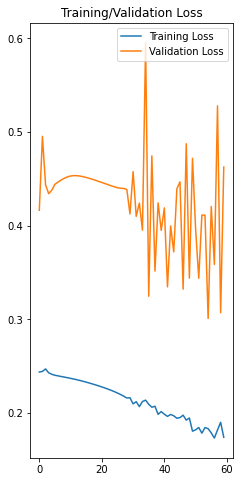

[array([[65.37806]], dtype=float32), array([[211.41144]], dtype=float32), array([[250.16241]], dtype=float32), array([[100.252525]], dtype=float32), array([[153.57751]], dtype=float32), array([[218.98796]], dtype=float32), array([[185.00038]], dtype=float32), array([[131.47372]], dtype=float32), array([[193.02849]], dtype=float32), array([[189.31525]], dtype=float32), array([[162.71405]], dtype=float32), array([[194.88203]], dtype=float32), array([[233.24661]], dtype=float32), array([[209.35345]], dtype=float32), array([[209.91052]], dtype=float32)]
[65.37806, 211.41144, 250.16241, 100.252525, 153.57751, 218.98796, 185.00038, 131.47372, 193.02849, 189.31525, 162.71405, 194.88203, 233.24661, 209.35345, 209.91052]


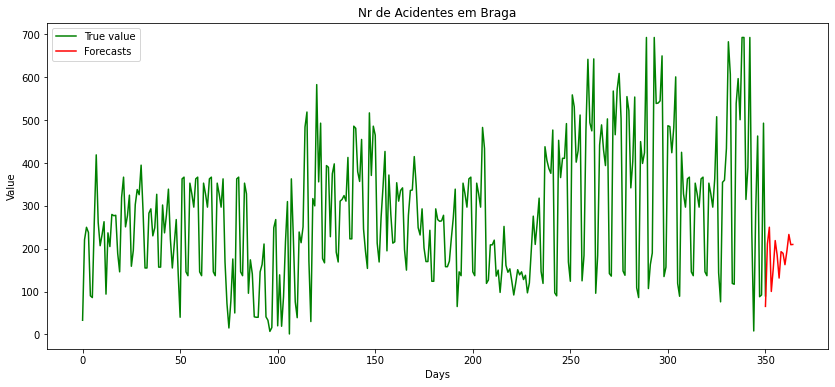

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 8, 64)             16896     
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
16/16 [==============================] - 5s 70ms/step - loss: 0.3010 - mae: 0.2632 - rmse: 0.3014 - val_loss: 0.3240 - val_mae: 0.2898 - val_rmse: 0.3021
Epoch 2/90
16/16 [==============================] - 0s 13ms/step - loss: 0.2187 - m

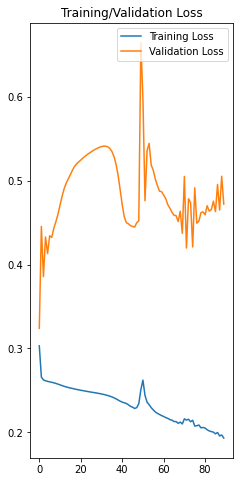

Epoch 1/90
31/31 [==============================] - 0s 15ms/step - loss: 0.3384 - mae: 0.2946 - rmse: 0.3378 - val_loss: 0.2264 - val_mae: 0.2180 - val_rmse: 0.2228
Epoch 2/90
31/31 [==============================] - 0s 13ms/step - loss: 0.2882 - mae: 0.2508 - rmse: 0.2870 - val_loss: 0.2537 - val_mae: 0.2261 - val_rmse: 0.2814
Epoch 3/90
31/31 [==============================] - 0s 12ms/step - loss: 0.2763 - mae: 0.2369 - rmse: 0.2753 - val_loss: 0.2507 - val_mae: 0.2155 - val_rmse: 0.2762
Epoch 4/90
31/31 [==============================] - 0s 13ms/step - loss: 0.2892 - mae: 0.2502 - rmse: 0.2881 - val_loss: 0.2370 - val_mae: 0.2115 - val_rmse: 0.2486
Epoch 5/90
31/31 [==============================] - 0s 13ms/step - loss: 0.2664 - mae: 0.2261 - rmse: 0.2655 - val_loss: 0.2423 - val_mae: 0.2077 - val_rmse: 0.2604

Epoch 00005: val_loss improved from 0.41312 to 0.24234, saving model to my_model_5_0.242.h5
Epoch 6/90
31/31 [==============================] - 0s 13ms/step - loss: 0.2646 - 

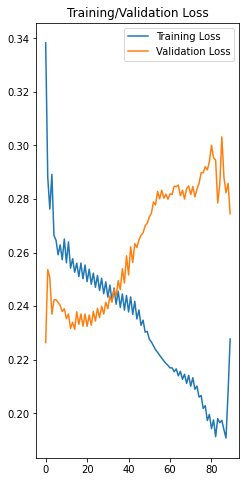

Epoch 1/90
47/47 [==============================] - 1s 31ms/step - loss: 0.2283 - mae: 0.1985 - rmse: 0.2283 - val_loss: 0.5080 - val_mae: 0.4654 - val_rmse: 0.5080
Epoch 2/90
47/47 [==============================] - 1s 12ms/step - loss: 0.2283 - mae: 0.1982 - rmse: 0.2274 - val_loss: 0.3897 - val_mae: 0.3423 - val_rmse: 0.3897
Epoch 3/90
47/47 [==============================] - 1s 12ms/step - loss: 0.2168 - mae: 0.1869 - rmse: 0.2151 - val_loss: 0.4957 - val_mae: 0.4574 - val_rmse: 0.4957
Epoch 4/90
47/47 [==============================] - 1s 13ms/step - loss: 0.2235 - mae: 0.1953 - rmse: 0.2222 - val_loss: 0.3799 - val_mae: 0.3376 - val_rmse: 0.3799
Epoch 5/90
47/47 [==============================] - 1s 12ms/step - loss: 0.2104 - mae: 0.1816 - rmse: 0.2083 - val_loss: 0.4693 - val_mae: 0.4278 - val_rmse: 0.4693

Epoch 00005: val_loss did not improve from 0.23137
Epoch 6/90
47/47 [==============================] - 1s 12ms/step - loss: 0.2165 - mae: 0.1896 - rmse: 0.2152 - val_loss: 0.

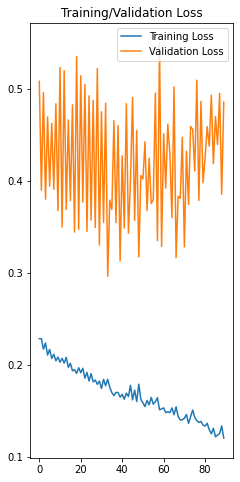

[array([[138.09984]], dtype=float32), array([[133.93872]], dtype=float32), array([[157.62218]], dtype=float32), array([[110.30458]], dtype=float32), array([[129.7325]], dtype=float32), array([[327.81564]], dtype=float32), array([[343.64938]], dtype=float32), array([[287.527]], dtype=float32), array([[261.62265]], dtype=float32), array([[198.79477]], dtype=float32), array([[157.32823]], dtype=float32), array([[97.649254]], dtype=float32), array([[189.80737]], dtype=float32), array([[226.63602]], dtype=float32), array([[340.04172]], dtype=float32)]
[138.09984, 133.93872, 157.62218, 110.30458, 129.7325, 327.81564, 343.64938, 287.527, 261.62265, 198.79477, 157.32823, 97.649254, 189.80737, 226.63602, 340.04172]


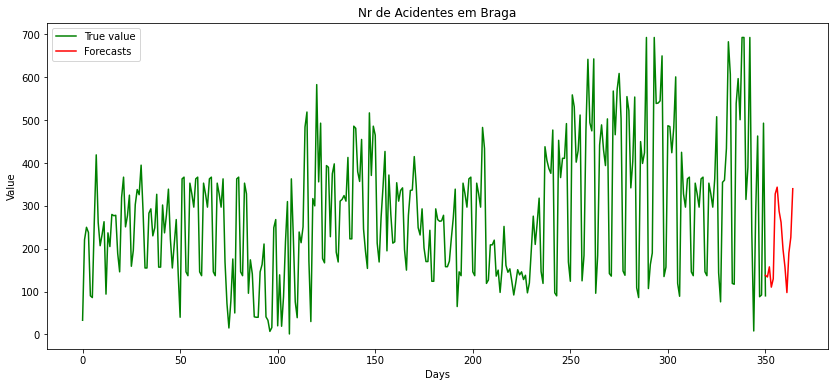

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 8, 64)             16896     
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
16/16 [==============================] - 4s 71ms/step - loss: 0.3032 - mae: 0.2653 - rmse: 0.3035 - val_loss: 0.3193 - val_mae: 0.2847 - val_rmse: 0.2981
Epoch 2/120
16/16 [==============================] - 0s 14ms/step - loss: 0.2197 -

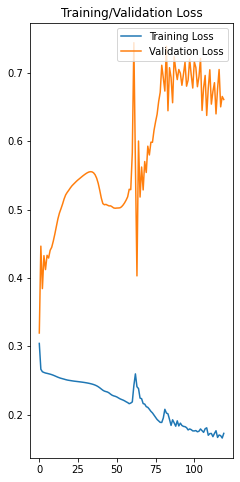

Epoch 1/120
31/31 [==============================] - 0s 16ms/step - loss: 0.3647 - mae: 0.3202 - rmse: 0.3645 - val_loss: 0.2711 - val_mae: 0.2404 - val_rmse: 0.2643
Epoch 2/120
31/31 [==============================] - 0s 13ms/step - loss: 0.3121 - mae: 0.2727 - rmse: 0.3110 - val_loss: 0.2430 - val_mae: 0.2038 - val_rmse: 0.2638
Epoch 3/120
31/31 [==============================] - 0s 14ms/step - loss: 0.2801 - mae: 0.2421 - rmse: 0.2791 - val_loss: 0.2444 - val_mae: 0.2136 - val_rmse: 0.2585
Epoch 4/120
31/31 [==============================] - 0s 13ms/step - loss: 0.2716 - mae: 0.2327 - rmse: 0.2707 - val_loss: 0.2343 - val_mae: 0.2033 - val_rmse: 0.2422
Epoch 5/120
31/31 [==============================] - 0s 13ms/step - loss: 0.2658 - mae: 0.2267 - rmse: 0.2649 - val_loss: 0.2356 - val_mae: 0.2045 - val_rmse: 0.2407

Epoch 00005: val_loss improved from 0.41212 to 0.23562, saving model to my_model_5_0.236.h5
Epoch 6/120
31/31 [==============================] - 0s 13ms/step - loss: 0.2

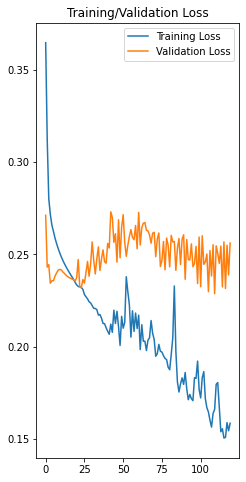

Epoch 1/120
47/47 [==============================] - 2s 40ms/step - loss: 0.1892 - mae: 0.1621 - rmse: 0.1896 - val_loss: 0.5159 - val_mae: 0.4245 - val_rmse: 0.5159
Epoch 2/120
47/47 [==============================] - 1s 12ms/step - loss: 0.1911 - mae: 0.1625 - rmse: 0.1912 - val_loss: 0.4540 - val_mae: 0.3810 - val_rmse: 0.4540
Epoch 3/120
47/47 [==============================] - 1s 13ms/step - loss: 0.1856 - mae: 0.1608 - rmse: 0.1855 - val_loss: 0.5634 - val_mae: 0.4425 - val_rmse: 0.5634
Epoch 4/120
47/47 [==============================] - 1s 12ms/step - loss: 0.1795 - mae: 0.1502 - rmse: 0.1787 - val_loss: 0.3998 - val_mae: 0.3135 - val_rmse: 0.3998
Epoch 5/120
47/47 [==============================] - 1s 13ms/step - loss: 0.1786 - mae: 0.1535 - rmse: 0.1777 - val_loss: 0.4646 - val_mae: 0.3443 - val_rmse: 0.4646

Epoch 00005: val_loss did not improve from 0.22860
Epoch 6/120
47/47 [==============================] - 1s 12ms/step - loss: 0.1740 - mae: 0.1454 - rmse: 0.1728 - val_lo

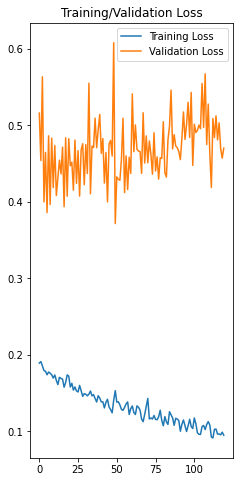

[array([[152.21466]], dtype=float32), array([[171.71075]], dtype=float32), array([[167.71516]], dtype=float32), array([[142.0795]], dtype=float32), array([[227.72708]], dtype=float32), array([[112.22559]], dtype=float32), array([[186.72891]], dtype=float32), array([[212.545]], dtype=float32), array([[255.52873]], dtype=float32), array([[275.26126]], dtype=float32), array([[321.46933]], dtype=float32), array([[237.23117]], dtype=float32), array([[170.30515]], dtype=float32), array([[175.18129]], dtype=float32), array([[309.55228]], dtype=float32)]
[152.21466, 171.71075, 167.71516, 142.0795, 227.72708, 112.22559, 186.72891, 212.545, 255.52873, 275.26126, 321.46933, 237.23117, 170.30515, 175.18129, 309.55228]


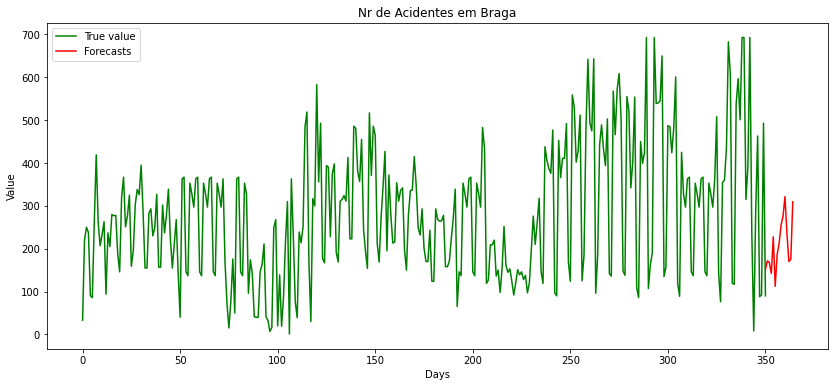

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 4s 117ms/step - loss: 0.3160 - mae: 0.2668 - rmse: 0.3165 - val_loss: 0.3314 - val_mae: 0.2785 - val_rmse: 0.3314
Epoch 2/50
10/10 [==============================] - 0s 21ms/step - loss: 0.2347 - 

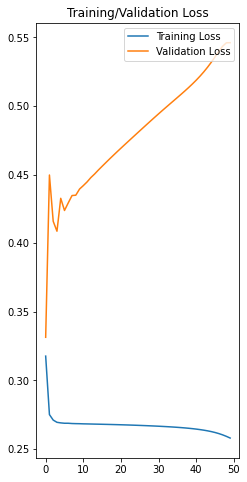

Epoch 1/50
20/20 [==============================] - 0s 20ms/step - loss: 0.3252 - mae: 0.2714 - rmse: 0.3148 - val_loss: 0.2808 - val_mae: 0.2283 - val_rmse: 0.2808
Epoch 2/50
20/20 [==============================] - 0s 16ms/step - loss: 0.3198 - mae: 0.2782 - rmse: 0.3102 - val_loss: 0.2498 - val_mae: 0.2111 - val_rmse: 0.2498
Epoch 3/50
20/20 [==============================] - 0s 17ms/step - loss: 0.3084 - mae: 0.2601 - rmse: 0.2950 - val_loss: 0.2695 - val_mae: 0.2226 - val_rmse: 0.2695
Epoch 4/50
20/20 [==============================] - 0s 18ms/step - loss: 0.3027 - mae: 0.2558 - rmse: 0.2902 - val_loss: 0.2649 - val_mae: 0.2271 - val_rmse: 0.2649
Epoch 5/50
20/20 [==============================] - 0s 17ms/step - loss: 0.3014 - mae: 0.2574 - rmse: 0.2900 - val_loss: 0.2576 - val_mae: 0.2217 - val_rmse: 0.2576

Epoch 00005: val_loss improved from 0.43270 to 0.25762, saving model to my_model_5_0.258.h5
Epoch 6/50
20/20 [==============================] - 0s 16ms/step - loss: 0.2975 - 

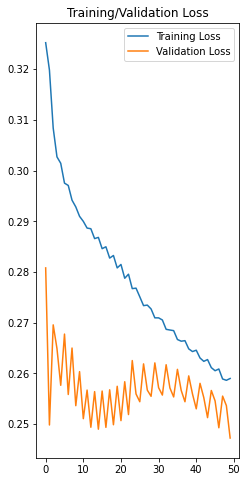

Epoch 1/50
29/29 [==============================] - 1s 19ms/step - loss: 0.2578 - mae: 0.2095 - rmse: 0.2598 - val_loss: 0.3984 - val_mae: 0.3251 - val_rmse: 0.3492
Epoch 2/50
29/29 [==============================] - 0s 16ms/step - loss: 0.2563 - mae: 0.2141 - rmse: 0.2578 - val_loss: 0.3793 - val_mae: 0.3204 - val_rmse: 0.3347
Epoch 3/50
29/29 [==============================] - 0s 16ms/step - loss: 0.2541 - mae: 0.2125 - rmse: 0.2556 - val_loss: 0.3876 - val_mae: 0.3259 - val_rmse: 0.3425
Epoch 4/50
29/29 [==============================] - 0s 16ms/step - loss: 0.2519 - mae: 0.2100 - rmse: 0.2534 - val_loss: 0.3837 - val_mae: 0.3206 - val_rmse: 0.3351
Epoch 5/50
29/29 [==============================] - 0s 16ms/step - loss: 0.2502 - mae: 0.2080 - rmse: 0.2517 - val_loss: 0.3772 - val_mae: 0.3141 - val_rmse: 0.3245

Epoch 00005: val_loss did not improve from 0.24722
Epoch 6/50
29/29 [==============================] - 0s 15ms/step - loss: 0.2489 - mae: 0.2066 - rmse: 0.2503 - val_loss: 0.

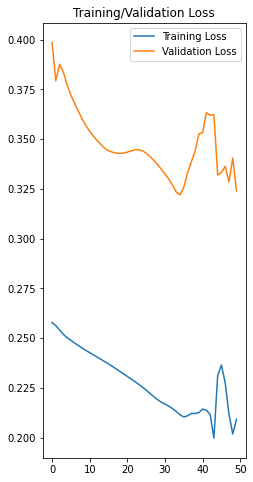

[array([[109.75989]], dtype=float32), array([[312.42377]], dtype=float32), array([[299.2084]], dtype=float32), array([[296.01804]], dtype=float32), array([[240.27568]], dtype=float32), array([[344.63318]], dtype=float32), array([[308.21536]], dtype=float32), array([[225.91942]], dtype=float32), array([[360.1329]], dtype=float32), array([[348.25403]], dtype=float32), array([[331.27258]], dtype=float32), array([[306.4976]], dtype=float32), array([[323.36792]], dtype=float32), array([[274.67773]], dtype=float32), array([[297.64227]], dtype=float32)]
[109.75989, 312.42377, 299.2084, 296.01804, 240.27568, 344.63318, 308.21536, 225.91942, 360.1329, 348.25403, 331.27258, 306.4976, 323.36792, 274.67773, 297.64227]


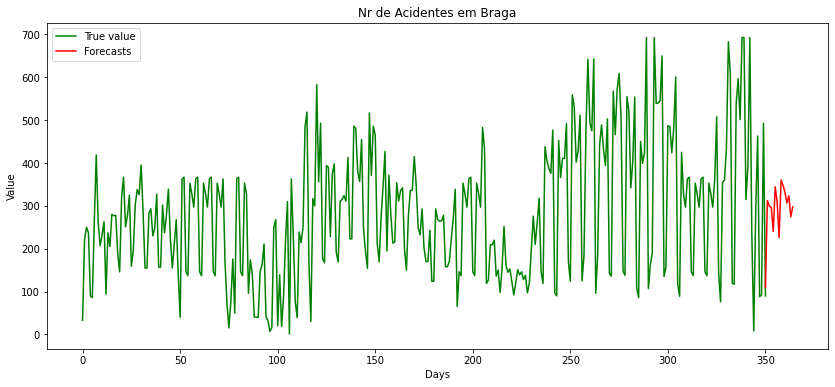

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/90
10/10 [==============================] - 4s 112ms/step - loss: 0.2951 - mae: 0.2489 - rmse: 0.2959 - val_loss: 0.3104 - val_mae: 0.2589 - val_rmse: 0.3104
Epoch 2/90
10/10 [==============================] - 0s 21ms/step - loss: 0.2363 - 

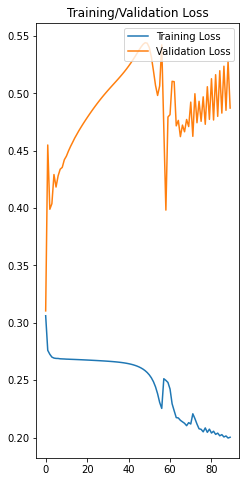

Epoch 1/90
20/20 [==============================] - 0s 20ms/step - loss: 0.3120 - mae: 0.2574 - rmse: 0.3000 - val_loss: 0.2655 - val_mae: 0.2380 - val_rmse: 0.2655
Epoch 2/90
20/20 [==============================] - 0s 18ms/step - loss: 0.3033 - mae: 0.2607 - rmse: 0.2908 - val_loss: 0.2663 - val_mae: 0.2095 - val_rmse: 0.2663
Epoch 3/90
20/20 [==============================] - 0s 17ms/step - loss: 0.3135 - mae: 0.2581 - rmse: 0.3005 - val_loss: 0.2641 - val_mae: 0.2436 - val_rmse: 0.2641
Epoch 4/90
20/20 [==============================] - 0s 17ms/step - loss: 0.2867 - mae: 0.2370 - rmse: 0.2755 - val_loss: 0.2603 - val_mae: 0.2352 - val_rmse: 0.2603
Epoch 5/90
20/20 [==============================] - 0s 18ms/step - loss: 0.2768 - mae: 0.2310 - rmse: 0.2654 - val_loss: 0.2619 - val_mae: 0.2349 - val_rmse: 0.2619

Epoch 00005: val_loss improved from 0.42920 to 0.26191, saving model to my_model_5_0.262.h5
Epoch 6/90
20/20 [==============================] - 0s 17ms/step - loss: 0.2762 - 

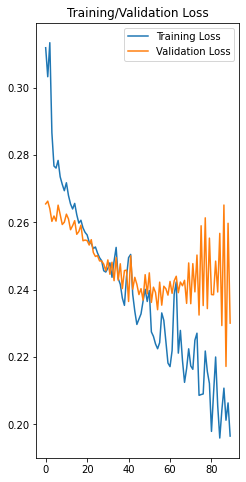

Epoch 1/90
29/29 [==============================] - 1s 19ms/step - loss: 0.2262 - mae: 0.1811 - rmse: 0.2287 - val_loss: 0.4347 - val_mae: 0.3406 - val_rmse: 0.3663
Epoch 2/90
29/29 [==============================] - 0s 17ms/step - loss: 0.2231 - mae: 0.1851 - rmse: 0.2248 - val_loss: 0.3767 - val_mae: 0.3228 - val_rmse: 0.3066
Epoch 3/90
29/29 [==============================] - 0s 17ms/step - loss: 0.2087 - mae: 0.1703 - rmse: 0.2109 - val_loss: 0.3995 - val_mae: 0.3283 - val_rmse: 0.3124
Epoch 4/90
29/29 [==============================] - 0s 16ms/step - loss: 0.2062 - mae: 0.1701 - rmse: 0.2087 - val_loss: 0.3986 - val_mae: 0.3313 - val_rmse: 0.3334
Epoch 5/90
29/29 [==============================] - 0s 17ms/step - loss: 0.2066 - mae: 0.1687 - rmse: 0.2089 - val_loss: 0.3987 - val_mae: 0.3282 - val_rmse: 0.3170

Epoch 00005: val_loss did not improve from 0.23007
Epoch 6/90
29/29 [==============================] - 0s 16ms/step - loss: 0.2010 - mae: 0.1630 - rmse: 0.2030 - val_loss: 0.

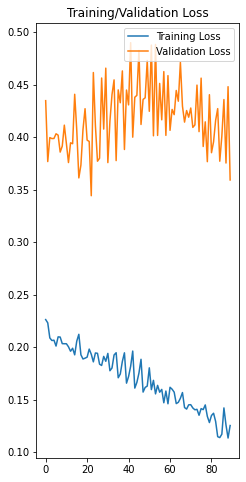

[array([[103.20047]], dtype=float32), array([[193.84544]], dtype=float32), array([[218.8128]], dtype=float32), array([[208.17595]], dtype=float32), array([[271.3567]], dtype=float32), array([[507.23825]], dtype=float32), array([[496.54272]], dtype=float32), array([[154.85179]], dtype=float32), array([[62.558376]], dtype=float32), array([[349.80893]], dtype=float32), array([[213.96086]], dtype=float32), array([[316.99127]], dtype=float32), array([[173.29918]], dtype=float32), array([[285.46774]], dtype=float32), array([[200.44774]], dtype=float32)]
[103.20047, 193.84544, 218.8128, 208.17595, 271.3567, 507.23825, 496.54272, 154.85179, 62.558376, 349.80893, 213.96086, 316.99127, 173.29918, 285.46774, 200.44774]


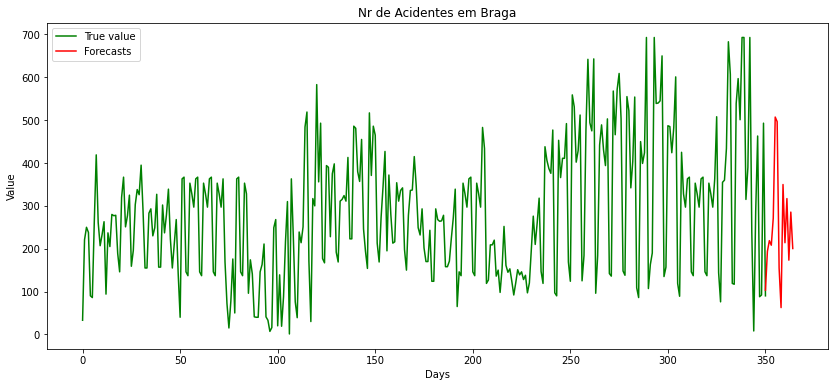

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10, 64)            16896     
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 31,489
Trainable params: 31,489
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
10/10 [==============================] - 5s 130ms/step - loss: 0.3246 - mae: 0.2755 - rmse: 0.3249 - val_loss: 0.3421 - val_mae: 0.2900 - val_rmse: 0.3421
Epoch 2/120
10/10 [==============================] - 0s 21ms/step - loss: 0.2344 

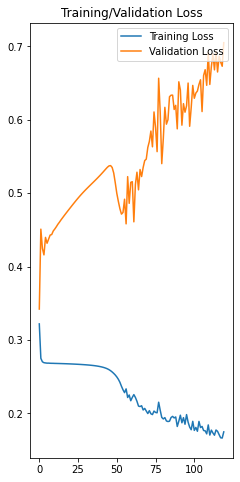

Epoch 1/120
20/20 [==============================] - 0s 21ms/step - loss: 0.3358 - mae: 0.2690 - rmse: 0.3244 - val_loss: 0.3110 - val_mae: 0.2768 - val_rmse: 0.3110
Epoch 2/120
20/20 [==============================] - 0s 17ms/step - loss: 0.3103 - mae: 0.2616 - rmse: 0.3007 - val_loss: 0.2636 - val_mae: 0.2256 - val_rmse: 0.2636
Epoch 3/120
20/20 [==============================] - 0s 24ms/step - loss: 0.2891 - mae: 0.2480 - rmse: 0.2792 - val_loss: 0.2865 - val_mae: 0.2318 - val_rmse: 0.2865
Epoch 4/120
20/20 [==============================] - 1s 25ms/step - loss: 0.2935 - mae: 0.2509 - rmse: 0.2822 - val_loss: 0.2772 - val_mae: 0.2422 - val_rmse: 0.2772
Epoch 5/120
20/20 [==============================] - 0s 18ms/step - loss: 0.2919 - mae: 0.2420 - rmse: 0.2795 - val_loss: 0.2696 - val_mae: 0.2492 - val_rmse: 0.2696

Epoch 00005: val_loss improved from 0.43976 to 0.26962, saving model to my_model_5_0.270.h5
Epoch 6/120
20/20 [==============================] - 0s 19ms/step - loss: 0.2

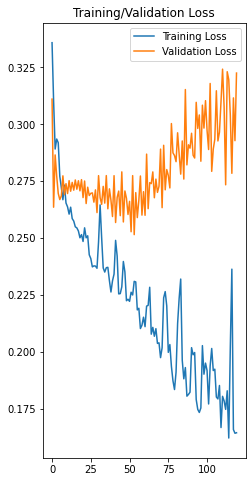

Epoch 1/120
29/29 [==============================] - 1s 20ms/step - loss: 0.2285 - mae: 0.1935 - rmse: 0.2312 - val_loss: 0.4463 - val_mae: 0.3782 - val_rmse: 0.4346
Epoch 2/120
29/29 [==============================] - 0s 17ms/step - loss: 0.2424 - mae: 0.2013 - rmse: 0.2455 - val_loss: 0.4755 - val_mae: 0.3898 - val_rmse: 0.4145
Epoch 3/120
29/29 [==============================] - 1s 19ms/step - loss: 0.2348 - mae: 0.1960 - rmse: 0.2377 - val_loss: 0.3800 - val_mae: 0.3064 - val_rmse: 0.3193
Epoch 4/120
29/29 [==============================] - 0s 16ms/step - loss: 0.2106 - mae: 0.1732 - rmse: 0.2138 - val_loss: 0.4127 - val_mae: 0.3323 - val_rmse: 0.3595
Epoch 5/120
29/29 [==============================] - 1s 18ms/step - loss: 0.2006 - mae: 0.1653 - rmse: 0.2036 - val_loss: 0.4102 - val_mae: 0.3425 - val_rmse: 0.3802

Epoch 00005: val_loss did not improve from 0.25949
Epoch 6/120
29/29 [==============================] - 1s 17ms/step - loss: 0.2036 - mae: 0.1682 - rmse: 0.2070 - val_lo

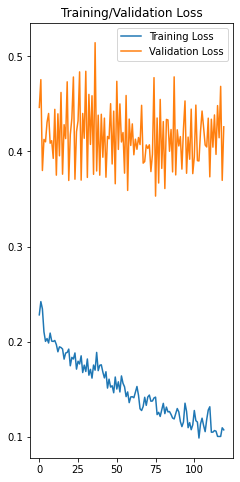

[array([[176.79654]], dtype=float32), array([[218.1609]], dtype=float32), array([[130.79768]], dtype=float32), array([[151.62321]], dtype=float32), array([[145.23772]], dtype=float32), array([[165.26642]], dtype=float32), array([[134.76514]], dtype=float32), array([[274.8517]], dtype=float32), array([[244.58176]], dtype=float32), array([[159.30473]], dtype=float32), array([[129.20885]], dtype=float32), array([[222.71793]], dtype=float32), array([[254.35936]], dtype=float32), array([[239.61172]], dtype=float32), array([[159.96187]], dtype=float32)]
[176.79654, 218.1609, 130.79768, 151.62321, 145.23772, 165.26642, 134.76514, 274.8517, 244.58176, 159.30473, 129.20885, 222.71793, 254.35936, 239.61172, 159.96187]


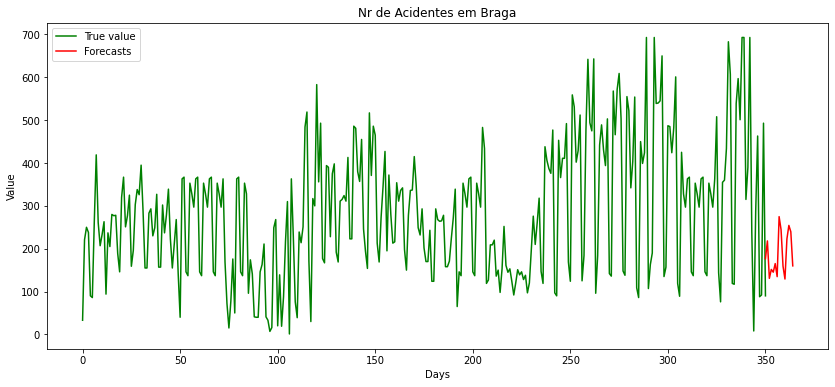

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.29243050813674926, 0.2526225010553996, 0.29361416002114615, 0.36858490208784733, 0.3285224492351214, 0.36174277762571966] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.23542032827933626, 0.20086751401424408, 0.23705230305592218, 0.41255941887696584, 0.376755979458491, 0.4146024297674497] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.20464047561089196, 0.1733346279958884, 0.2057160206635793, 0.428572096178929, 0.3841955292721589, 0.43480869313081105] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.23904846981167793, 0.20706804460949368, 0.23910071328282356, 0.39216019395324925, 0.34991910441054236, 0.3877993506689867] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.21179358051330954, 0.18418868134419122, 0.2117621743016773, 0.3896741639684748, 0.3483924754239895, 0.3845562169

In [20]:
pd.DataFrame.from_dict(final_dict, orient='index',columns=['Loss', 'MAE', 'RMSE', 'VAL_LOSS', 'VAL_MAE', 'VAL_RMSE'])

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.292431,0.252623,0.293614,0.368585,0.328522,0.361743
2,0.235420,0.200868,0.237052,0.412559,0.376756,0.414602
3,0.204640,0.173335,0.205716,0.428572,0.384196,0.434809
4,0.239048,0.207068,0.239101,0.392160,0.349919,0.387799
5,0.211794,0.184189,0.211762,0.389674,0.348392,0.384556
6,0.186013,0.160423,0.185984,0.433116,0.379489,0.429506
7,0.258090,0.221146,0.255909,0.361107,0.316693,0.341729
8,0.218284,0.183641,0.216416,0.384060,0.339789,0.361592
9,0.199294,0.166355,0.197501,0.414999,0.369681,0.394649
